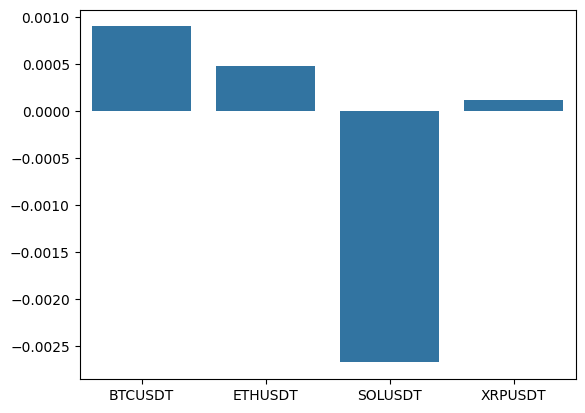

-0.001382515877817916

In [56]:
#thaydoi
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy 

def classical(mu, sigma):
    returns = data['mu']
    covar = data['sigma']

    assets = []
    costs = []
    for row in data['assets']:
        assets.append(row["Asset"])
        costs.append(float(row["Open"]))

    # Half the money
    budget = np.sum(costs)/0.5
    # Our solution variable
    x_val = cp.Variable(len(returns), boolean=True)
    theta = cp.Parameter(nonneg=True)
    ret = np.array(returns)@x_val
    risk = cp.quad_form(x_val, covar)
    e_costs = np.array(costs)@x_val

    # Constraints
    cons = [cp.sum(x_val) >= 0, cp.sum(e_costs) <= budget, x_val >= 0]

    # Objective function
    obj = cp.Minimize(- ret + theta*risk)

    # Problem
    prob = cp.Problem(obj, cons)
    theta.value = 0.03 # This is related to the risk penalty lagrangian
    prob.solve(solver='ECOS_BB')
    #the result represents the optimal value of the objective function after solving the optimization problem

We will use CVX and its Python implementation (cvxpy) with a mixed integer optimization approach as our problem is restricted by the boolean values our $x$ variables can take, created for convex optimization; itself isn't a solver, it is a modeling framework

In [67]:
import csv
import pickle
import pandas as pd
import sys
import os

# Load the DataFrame from a file if it exists
if os.path.isfile('cvx.pkl'):
    df = pd.read_pickle('cvx.pkl')
else:
    df = pd.DataFrame(columns=['Num_Symbols', 'cvx_val_list'])

cvxselection = f"{n}assetcvx.csv"
cvx_val_list = []  # Initialize an empty list to store the values

with open(cvxselection, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Asset", "Selected"])

    for i, val in enumerate(np.round(x_val.value,1)):
        cvx_val_list.append(val)  # Add the value to the list
        if val == 1:
            writer.writerow([assets[i], 1])
        else:
            writer.writerow([assets[i], 0])

with open('cvx.pkl', 'wb') as f:
    pickle.dump(cvx_val_list, f)
with open('cvx.pkl', 'rb') as f:
    val_list = pickle.load(f)
# Create a new DataFrame with a single row
new_row = pd.DataFrame({'Num_Symbols': [len(cvx_val_list)], 'cvx_val_list': [val_list]})
print(type(new_row))
# Append the new row to the existing DataFrame
df = pd.concat([df, new_row], ignore_index=True)

# Save the DataFrame to a file
df.to_pickle('cvx.pkl')

print(df)
os.remove(cvxselection)

<class 'pandas.core.frame.DataFrame'>
  Num_Symbols          cvx_val_list
0           4  [1.0, 1.0, 0.0, 1.0]
1           4  [1.0, 1.0, 0.0, 1.0]
2           4  [1.0, 1.0, 0.0, 1.0]
3           4  [1.0, 1.0, 0.0, 1.0]
4           4  [1.0, 1.0, 0.0, 1.0]
5           4  [1.0, 1.0, 0.0, 1.0]
